<CENTER>
</br>
<p><font size="5">  M2MO & EY - Internship </font></p>
<p><font size="5">  Modelling Initial Margin and Counterparty Risk in Uncleared Derivatives </font></p>
<p><font size="4">  SANGLIER Nathan </font></p>
<p><font size="3"></br>May 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@etu.u-paris.fr</span>
</p>
</CENTER>

In [ ]:
import  numpy                                       as      np
import  matplotlib.pyplot                           as      plt
import  statsmodels.api                             as      sm
from    time                                        import  time
from    scipy.stats                                 import  norm
from    scipy.special                               import  eval_genlaguerre, comb
from    sklearn.linear_model                        import  LinearRegression, Ridge, HuberRegressor
from    statsmodels.nonparametric.kernel_regression import  KernelReg

np.random.seed(0)
plt.style.use('ggplot')

In [59]:
color_jlsmc     = 'blue'
color_invalid   = 'purple'

In [ ]:
# 1/24 = 1 week. 1Y = 6M | 1M = 4W --> 1Y = 24W
# 1/240 = 1/2 bday. 1W = 5 bdays
r, S0, sigma, T, delta, dt = 0.05, 100, 0.3, 1, 1/24, 1/240

time_grid   = np.arange(0, T, dt)
N           = len(time_grid)-1
M           = 200000
tref        = 1/12 # 1/12 : 1 month
ind_tref, ind_delta, ind_tdelta = int(tref/dt), int(delta/dt), int((tref+delta)/dt)
Sref        = 100 # 100
alpha       = 0.99
K           = 95

jtypes_map      = {'SL': 1, 'SU': 2, 'SB': 3, 'SN': 4, 'ST': 5}
rev_jtypes_map  = {v: k for k, v in jtypes_map.items()}

In [ ]:
def gen_S(S0, M, N):
    paths           = np.zeros((M, N+1))
    paths[:, 0]     = S0
    Z               = np.random.normal(0, 1, size=(M, N))
    increments      = np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    paths[:, 1:]    = S0 * np.cumprod(increments, axis=1)
    return paths

gen_S(np.array([100, 200]), 3, 4)

ValueError: could not broadcast input array from shape (2,) into shape (3,)

In [77]:
a = np.array([[1, 2, 3], [4, 5, 6]])
a[:, -1:]

array([[3],
       [6]])

In [78]:
np.column_stack((a, a[:, -1:]))  # add last column to the end

array([[1, 2, 3, 3],
       [4, 5, 6, 6]])

In [ ]:
def beta(t):
    return np.exp(-r*t)

def gen_riskfactors(S0, M, N):
    paths           = np.zeros((M, N+1))
    paths[:, 0]     = S0
    Z               = np.random.normal(0, 1, size=(M, N))
    increments      = np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    paths[:, 1:]    = S0 * np.cumprod(increments, axis=1)
    return paths

def gen_mtm(S_paths, time_grid):
    M   = S_paths.shape[0]
    N   = S_paths.shape[1]-1
    mtm = np.zeros((M, N+1))
    for i in range(N+1):
        d1          = (np.log(S_paths[:, i]/K) + (r + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        mtm[:, i]   = K*beta(T-time_grid[i])*norm.cdf(-d2) - S_paths[:, i]*norm.cdf(-d1)
        
    return mtm

def get_mtmdiff_nmc(M, M_in, S, ind_tref):
    mtmdiff     = np.zeros((M, M_in))
    ind_tdelta  = ind_tref + ind_delta
    for m in range(M):
        S_paths_nested     = gen_riskfactors(S[m], M_in, ind_delta)
        mtm_paths_nested   = gen_mtm(np.column_stack([np.ones((M_in, 1))*S[m], S_paths_nested[:, -1:]]), np.array([time_grid[ind_tref], time_grid[ind_tdelta]]))
        mtmdiff[m, :]               = mtm_paths_nested[m, :, -1] - mtm_paths_nested[m, :, 0]

        np.array([time_grid[ind_tref], time_grid[ind_tdelta]])
    
    mu1raw = np.mean(mtmdiff, axis=1)
    mu2raw = np.mean(mtmdiff**2, axis=1)
    mu3raw = np.mean(mtmdiff**3, axis=1)
    mu4raw = np.mean(mtmdiff**4, axis=1)
    mu2, mu3, mu4 = get_mu2(mu1raw, mu2raw), get_mu3(mu1raw, mu2raw, mu3raw), get_mu4(mu1raw, mu2raw, mu3raw, mu4raw)
    skew     = get_skew(mu3, mu2)
    kurt     = get_kurt(mu4, mu2)

    return mtm_paths_nested, mtmdiff, mu1raw, mu2raw, mu3raw, mu4raw, mu2, mu3, mu4, skew, kurt


def get_basis(mtm, basis_type, order):
    if basis_type == 'laguerre':
        return np.column_stack([eval_genlaguerre(s, 0, mtm) for s in range(order+1)])
    elif basis_type == 'canonical':
        return np.column_stack([mtm**s for s in range(order+1)])


def regress_moms(mtm_train, y_train, mtm_pred_list, setting, order_moms):
    start = time()
    method          = setting['method']
    ind_start       = 1 if setting['regress_mean']==True else 2
    yhat_pred_list  = []
    X_pred_list     = []

    for mtm in mtm_pred_list:
        yhat_pred   = np.zeros((len(mtm), order_moms+1))
        yhat_pred_list.append(yhat_pred)
    if (method == 'LR') or (method == 'HR') or (method == 'GLM'):
        X_train = get_basis(mtm_train, setting['basis_type'], setting['order'])
        for mtm in mtm_pred_list:
            X_pred = get_basis(mtm, setting['basis_type'], setting['order'])
            X_pred_list.append(X_pred)
        for j in range(ind_start, order_moms+1):
            if j%2 != 0:
                if (method == 'LR') and (setting['ridge']>0):
                    model = Ridge(setting['ridge'], fit_intercept=False)
                elif method == 'HR':
                    model = HuberRegressor(epsilon=setting['epsilon'], alpha=setting['ridge'], fit_intercept=False)
                elif (method == 'LR') or (method == 'GLM'):
                    model = LinearRegression(fit_intercept=False)
                
                model.fit(X_train, y_train[:, j-1])
            else:
                if (method == 'LR') and (setting['ridge']>0):
                    model = Ridge(alpha=setting['ridge'], fit_intercept=False)
                elif method == 'LR':
                    model = LinearRegression(fit_intercept=False)
                elif method == 'HR':
                    model = HuberRegressor(epsilon=setting['epsilon'], alpha=setting['ridge'] ,fit_intercept=False)
                elif (method == 'GLM') and (setting['ridge']>0):
                    model = sm.GLM(y_train[:, j-1], X_train, family=sm.families.Gaussian(link=sm.families.links.Log())).fit_regularized(method='elastic_net', alpha=setting['ridge'], L1_wt=0)
                elif method == 'GLM':
                    model = sm.GLM(y_train[:, j-1], X_train, family=sm.families.Gaussian(link=sm.families.links.Log())).fit()
                
                if method != 'GLM':
                    model.fit(X_train, y_train[:, j-1])

            for i, mtm in enumerate(mtm_pred_list):
                yhat_pred_list[i][:, j-1] = model.predict(X_pred_list[i])
    
    elif method =='KR':

        X_train = mtm_train.reshape(-1, 1)
        iqr     = np.quantile(mtm_train, 0.75) - np.quantile(mtm_train, 0.25)
        slvm    = 0.9*min(np.std(mtm_train), iqr/1.34) * len(mtm_train)**(-1/5)
        for j in range(ind_start, order_moms+1):
            kr  = KernelReg(endog=y_train[:, j-1], exog=X_train, var_type='c', bw=[slvm])
            for i, mtm in enumerate(mtm_pred_list):
                X_pred = mtm.reshape(-1, 1)
                yhat_pred_list[i][:, j-1] = kr.fit(X_pred)[0]
    end = time()
    
    return yhat_pred_list, end-start


def get_centred_moms(yhat):
    M, K        = yhat.shape
    zhat        = np.column_stack([np.ones((M, 1)), yhat])
    pows        = np.arange(K+1)
    m1hat_pows  = zhat[:, 1:2]**pows
    temp        = np.ones(M, dtype=bool)

    muhat       = np.zeros((M, K-1))
    maskhat     = np.ones_like(muhat, dtype=bool)
    for k in range(2, K+1):
        coeffs          = (comb(k, pows[:k+1]) * (-1)**pows[k::-1]).reshape(1, -1)
        terms           = coeffs * zhat[:, :k+1] * m1hat_pows[:, k::-1]
        muhat[:, k-2]   = np.sum(terms, axis=1)
        if k%2 == 0:
            temp            &= (yhat[:, k]>0)
            maskhat[:, k-2] = temp&(muhat[:, k-2]>0)
        else:
            maskhat[:, k-2] = temp

    return muhat, maskhat

def get_skewkurt(muhat, maskhat=None):

    get_skew = lambda mu2, mu3: mu3 / mu2**(3/2)
    get_kurt = lambda mu2, mu4: mu4 / mu2**2

    if maskhat is None:
        maskhat = np.ones_like(muhat, dtype=bool)
    skewhat = get_skew(muhat[:, 1], muhat[:, 2])
    kurthat = get_kurt(muhat[:, 1], muhat[:, 3])

    mask_skewhat    = (maskhat[:, 1])&(maskhat[:, 2])
    mask_kurthat    = (maskhat[:, 1])&(maskhat[:, 3])
    mask_tothat     = (mask_skewhat)&(mask_kurthat)
    
    return skewhat, kurthat, mask_skewhat, mask_kurthat, mask_tothat

In [72]:
y = np.array(
    [[1, 2, 3, 4, 5],
     [0.1, 0.2, 0.3, 0.4, 0.5]]
)

k = 1

y[:, 1:k:2:2]>0, axis=1

SyntaxError: invalid syntax (140629780.py, line 8)

In [41]:
m1_pows[:, 3::-1]

array([[ 0,  0,  0,  1],
       [ 1,  1,  1,  1],
       [ 8,  4,  2,  1],
       [27,  9,  3,  1],
       [64, 16,  4,  1]])

In [ ]:
u = np.array([[1, 2, 3, 4], [5, 6, 7, 8]])



array([[1., 1., 2., 3., 4.],
       [1., 5., 6., 7., 8.]])

In [ ]:
np.co

In [ ]:
import numpy as np

def raw_to_central_moments(y):
    M, K = y.shape

    z = np.column_stack([np.ones((y.shape[0], 1)), y])
    res     = np.zeros((M, K-1))
    pows    = np.arange(K+1)
    m1_pows = z[:, 1:2]**pows

    for k in range(2, K+1):
        coeffs = (sp.comb(k, pows[:k+1]) * (-1)**pows[k::-1]).reshape(1, -1)
        terms = coeffs * z[:, :k+1]
        terms = terms * m1_pows[:, k::-1]
        res[:, k-2] = np.sum(terms, axis=1)

    return res


# Example: raw moments for two variables, up to order 4
raw_moments = np.array([
    [1.0, 2.0, 5.0, 15.0],  # E[X], E[X^2], ..., E[X^4] for sample 1
    [0.5, 1.5, 3.0, 8.0]    # for sample 2
])

central_moments = raw_to_central_moments(raw_moments)

print("Central moments:\n", central_moments)


Central moments:
 [[1.     1.     4.    ]
 [1.25   1.     4.0625]]


In [62]:
S_paths         = gen_S(S0, M, N)
mtm_paths       = gen_mtm_put(S_paths, time_grid)
mtmdiff_paths  = mtm_paths[:, ind_delta:] - mtm_paths[:, :-ind_delta]
mtm_train       = mtm_paths[:, ind_tref]

mtm_func        = np.linspace(np.min(mtm_train), np.max(mtm_train), 1000)

Nq          = 100
Nqtail      = int(0.1*Nq)//2
q_main      = np.arange(1, Nq) / Nq
q_ltail     = np.linspace(0, 0.01, Nqtail+2)[1:-1]
q_utail     = np.linspace(0.99, 1, Nqtail+2)[1:-1]
q_all       = np.sort(np.unique(np.concatenate([q_ltail, q_main, q_utail])))
mtm_supp    = np.quantile(mtm_train, q_all, method='inverted_cdf')

Mtest       = 100
Mtest_in    = 100000
S_test      = np.linspace(np.min(S_paths[:, ind_tref]), np.max(S_paths[:, ind_tref]), Mtest)
mtm_test_paths_nested, mtmdiff_test, mu1raw_test, mu2raw_test, mu3raw_test, mu4raw_test, mu2_test, mu3_test, mu4_test, skew_test, kurt_test = get_moms_nmc(Mtest, Mtest_in, S_test)
mtm_test    = mtm_test_paths_nested[:, 0, 0]

In [63]:
settings_list = [
    {'id': 0, 'method': 'LR', 'ridge': 0, 'S': 2},
    {'id': 1, 'method': 'LR', 'ridge': 0, 'S': 4},
    {'id': 2, 'method': 'HR', 'ridge': 0, 'epsilon': 100, 'S': 7}, # epsilon = 100, S = 2
    {'id': 3, 'method': 'GLM', 'ridge': 0, 'S': 2},
    {'id': 4, 'method': 'GLM', 'ridge': 0, 'S': 4},
    {'id': 5, 'method': 'KR'}
]

setting = settings_list[0]

In [64]:
mtm_pred_list_jlsmc = [mtm_test, mtm_func, mtm_supp]
y_train_jlsmc = mtmdiff_paths[:, ind_tref:ind_tref+1]**np.arange(1, order_mom+1)
y_train_glsmc = mtmdiff_paths[:, ind_tref]**2

yhat_pred_list_jlsmc, time_jlsmc = regress_moms_jlsmc(mtm_train, y_train_jlsmc, mtm_pred_list_jlsmc, setting)
print(f"Time taken for moments regression: {time_jlsmc:.2f} seconds")

mu1rawhat_test_jlsmc, mu2rawhat_test_jlsmc, mu3rawhat_test_jlsmc, mu4rawhat_test_jlsmc, mu2hat_test_jlsmc, mu3hat_test_jlsmc, mu4hat_test_jlsmc, skewhat_test_jlsmc, kurthat_test_jlsmc, mask_mu2hat_test_jlsmc, mask_mu3hat_test_jlsmc, mask_mu4hat_test_jlsmc, mask_skewhat_test_jlsmc, mask_kurthat_test_jlsmc, mask_tothat_test_jlsmc = get_moms_mask(yhat_pred_list_jlsmc[0])
mu1rawhat_func_jlsmc, mu2rawhat_func_jlsmc, mu3rawhat_func_jlsmc, mu4rawhat_func_jlsmc, mu2hat_func_jlsmc, mu3hat_func_jlsmc, mu4hat_func_jlsmc, skewhat_func_jlsmc, kurthat_func_jlsmc, mask_mu2hat_func_jlsmc, mask_mu3hat_func_jlsmc, mask_mu4hat_func_jlsmc, mask_skewhat_func_jlsmc, mask_kurthat_func_jlsmc, mask_tothat_func_jlsmc = get_moms_mask(yhat_pred_list_jlsmc[1])
mu1rawhat_supp_jlsmc, mu2rawhat_supp_jlsmc, mu3rawhat_supp_jlsmc, mu4rawhat_supp_jlsmc, mu2hat_supp_jlsmc, mu3hat_supp_jlsmc, mu4hat_supp_jlsmc, skewhat_supp_jlsmc, kurthat_supp_jlsmc, mask_mu2hat_supp_jlsmc, mask_mu3hat_supp_jlsmc, mask_mu4hat_supp_jlsmc, mask_skewhat_supp_jlsmc, mask_kurthat_supp_jlsmc, mask_tothat_supp_jlsmc = get_moms_mask(yhat_pred_list_jlsmc[2])

Time taken for moments regression: 0.06 seconds


C:\Users\CF518AW\AppData\Local\Temp\ipykernel_27556\2573433874.py:35: RuntimeWarning: invalid value encountered in power
  return mu3 / mu2**(3/2)


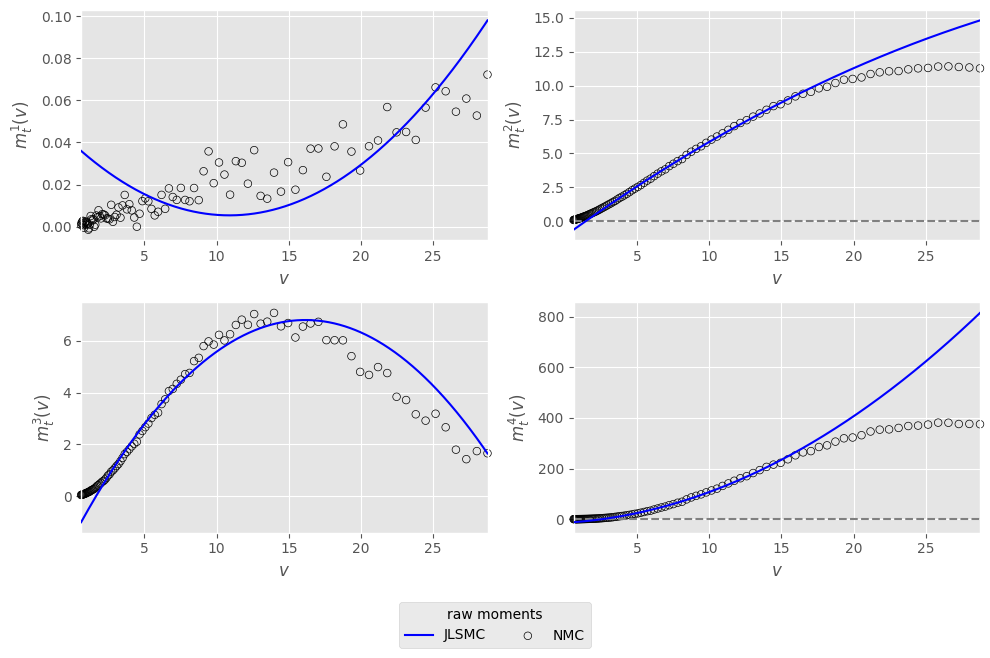

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].plot(mtm_func, mu1rawhat_func_jlsmc, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0, 0].scatter(mtm_test, mu1raw_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0, 0].set_xlabel('$v$')
axs[0, 0].set_ylabel('$m_t^1(v)$')
axs[0, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[0, 1].plot(mtm_func, mu2rawhat_func_jlsmc, color=color_jlsmc, zorder=3)
axs[0, 1].scatter(mtm_test, mu2raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[0, 1].axhline(0, color='grey', linestyle='--')
axs[0, 1].set_xlabel('$v$')
axs[0, 1].set_ylabel('$m_t^2(v)$')
axs[0, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 0].plot(mtm_func, mu3rawhat_func_jlsmc, color=color_jlsmc, zorder=3)
axs[1, 0].scatter(mtm_test, mu3raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1, 0].set_xlabel('$v$')
axs[1, 0].set_ylabel('$m_t^3(v)$')
axs[1, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 1].plot(mtm_func, mu4rawhat_func_jlsmc, color=color_jlsmc, zorder=3)
axs[1, 1].scatter(mtm_test, mu4raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1, 1].axhline(0, color='grey', linestyle='--')
axs[1, 1].set_xlabel('$v$')
axs[1, 1].set_ylabel('$m_t^4(v)$')
axs[1, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), title='raw moments')

plt.tight_layout()
# plt.savefig(f'figures/time_{tref:.2f}_set{setting['id']}_rawmoms.png', dpi=300, bbox_inches='tight')
plt.show()

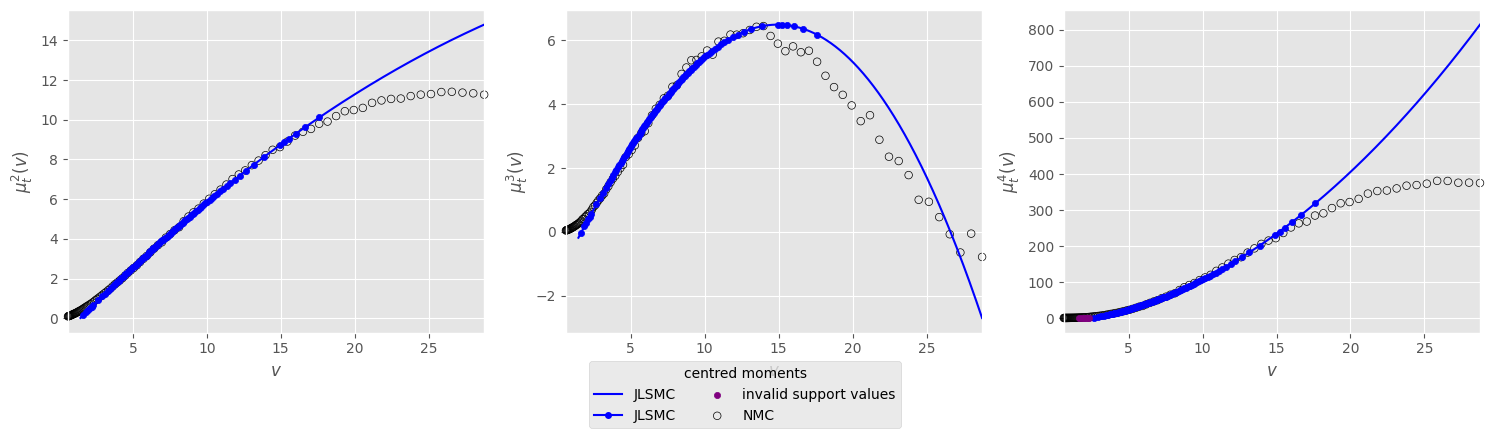

In [66]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(mtm_func[mask_mu2hat_func_jlsmc], mu2hat_func_jlsmc[mask_mu2hat_func_jlsmc], color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].scatter(mtm_supp[mask_mu2hat_supp_jlsmc], mu2hat_supp_jlsmc[mask_mu2hat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~mask_mu2hat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_mu2hat_supp_jlsmc]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[0].scatter(mtm_test, mu2_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\mu_t^2(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1].plot(mtm_func[mask_mu3hat_func_jlsmc], mu3hat_func_jlsmc[mask_mu3hat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[mask_mu3hat_supp_jlsmc], mu3hat_supp_jlsmc[mask_mu3hat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~mask_mu3hat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_mu3hat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, mu3_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\mu_t^3(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[2].plot(mtm_func[mask_mu4hat_func_jlsmc], mu4hat_func_jlsmc[mask_mu4hat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[2].scatter(mtm_supp[mask_mu4hat_supp_jlsmc], mu4hat_supp_jlsmc[mask_mu4hat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[2].scatter(mtm_supp[~mask_mu4hat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_mu4hat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[2].scatter(mtm_test, mu4_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[2].set_xlabel('$v$')
axs[2].set_ylabel('$\\mu_t^4(v)$')
axs[2].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1), title='centred moments')

plt.tight_layout()
plt.show()

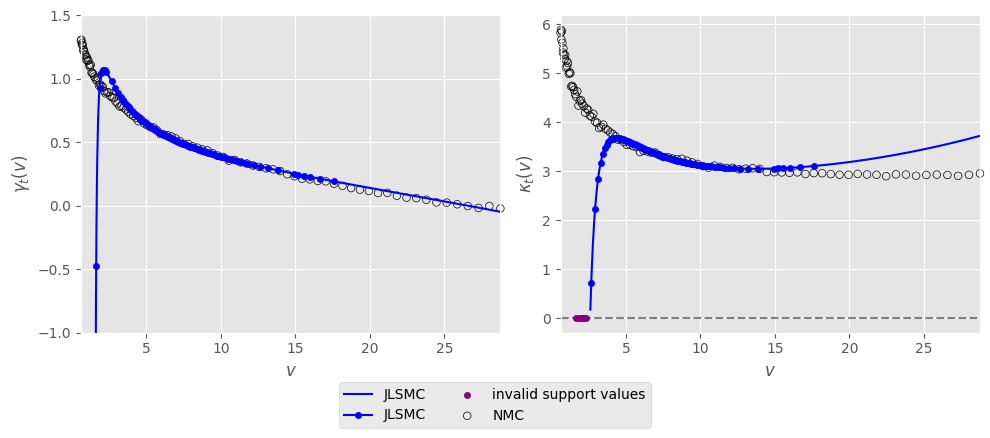

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(mtm_func[mask_skewhat_func_jlsmc], skewhat_func_jlsmc[mask_skewhat_func_jlsmc], color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].scatter(mtm_supp[mask_skewhat_supp_jlsmc], skewhat_supp_jlsmc[mask_skewhat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~mask_skewhat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_skewhat_supp_jlsmc]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[0].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\gamma_t(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))
axs[0].set_ylim(bottom=-1, top=1.5)

axs[1].plot(mtm_func[mask_kurthat_func_jlsmc], kurthat_func_jlsmc[mask_kurthat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[mask_kurthat_supp_jlsmc], kurthat_supp_jlsmc[mask_kurthat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~mask_kurthat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_kurthat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].axhline(0, color='grey', linestyle='--')
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\kappa_t(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

Total nummber of invalid support points: 6


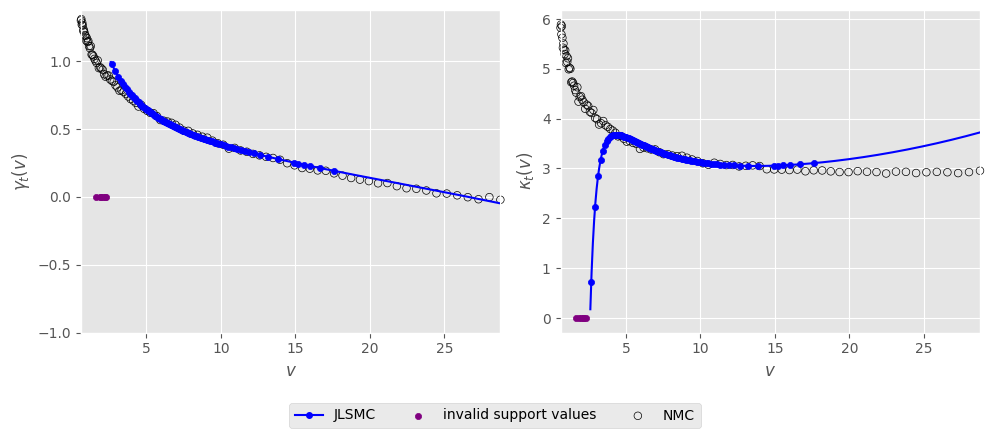

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(mtm_func[mask_tothat_func_jlsmc], skewhat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[0].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].scatter(mtm_supp[mask_tothat_supp_jlsmc], skewhat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[0].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\gamma_t(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))
axs[0].set_ylim(bottom=-1)

axs[1].plot(mtm_func[mask_tothat_func_jlsmc], kurthat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[mask_tothat_supp_jlsmc], kurthat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\kappa_t(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))

print(f"Total nummber of invalid support points: {np.sum(~mask_tothat_supp_jlsmc)}")

plt.tight_layout()
plt.show()

Total nummber of invalid support points: 6


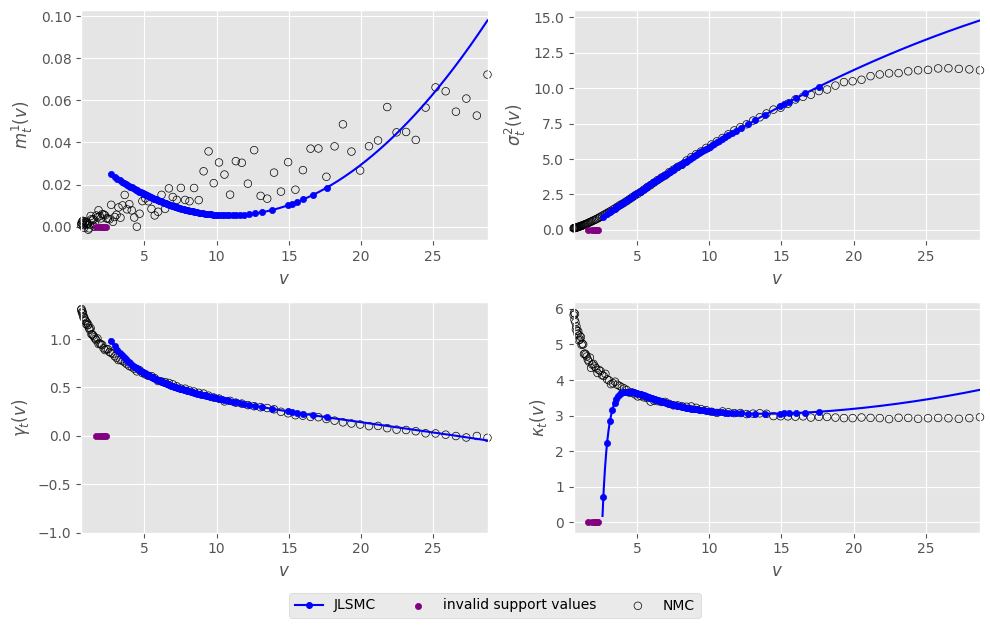

In [69]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.flatten()

axs[0].plot(mtm_func[mask_tothat_func_jlsmc], mu1rawhat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[0].scatter(mtm_supp[mask_tothat_supp_jlsmc], mu1rawhat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[0].scatter(mtm_test, mu1raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$m^1_t(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1].plot(mtm_func[mask_tothat_func_jlsmc], mu2hat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[mask_tothat_supp_jlsmc], mu2hat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, mu2_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\sigma^2_t(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[2].plot(mtm_func[mask_tothat_func_jlsmc], skewhat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[2].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[2].scatter(mtm_supp[mask_tothat_supp_jlsmc], skewhat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[2].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[2].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[2].set_xlabel('$v$')
axs[2].set_ylabel('$\\gamma_t(v)$')
axs[2].set_xlim(np.min(mtm_func), np.max(mtm_func))
axs[2].set_ylim(bottom=-1)

axs[3].plot(mtm_func[mask_tothat_func_jlsmc], kurthat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[3].scatter(mtm_supp[mask_tothat_supp_jlsmc], kurthat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[3].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[3].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[3].set_xlabel('$v$')
axs[3].set_ylabel('$\\kappa_t(v)$')
axs[3].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

print(f"Total nummber of invalid support points: {np.sum(~mask_tothat_supp_jlsmc)}")

plt.tight_layout()
# plt.savefig(f'figures/time_{tref:.2f}_set{setting['id']}_allmetrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.flatten()

axs[0].plot(mtm_func[mask_tothat_func_jlsmc], mu1rawhat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[0].scatter(mtm_supp[mask_tothat_supp_jlsmc], mu1rawhat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[0].scatter(mtm_test, mu1raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$m^1_t(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1].plot(mtm_func[mask_tothat_func_jlsmc], mu2hat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[mask_tothat_supp_jlsmc], mu2hat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, mu2_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\sigma^2_t(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[2].plot(mtm_func[mask_tothat_func_jlsmc], skewhat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[2].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[2].scatter(mtm_supp[mask_tothat_supp_jlsmc], skewhat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[2].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[2].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[2].set_xlabel('$v$')
axs[2].set_ylabel('$\\gamma_t(v)$')
axs[2].set_xlim(np.min(mtm_func), np.max(mtm_func))
axs[2].set_ylim(bottom=-1)

axs[3].plot(mtm_func[mask_tothat_func_jlsmc], kurthat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[3].scatter(mtm_supp[mask_tothat_supp_jlsmc], kurthat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[3].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[3].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[3].set_xlabel('$v$')
axs[3].set_ylabel('$\\kappa_t(v)$')
axs[3].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

print(f"Total nummber of invalid support points: {np.sum(~mask_tothat_supp_jlsmc)}")

plt.tight_layout()
plt.show()